In [1]:
#A code to fit continuum, pseudo-continuum, and/or baselines to image cubes from the JWST nirspec ifu
#By Adam E. Rubinstein

# load important packages
from glob import glob
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
import os
import sys

from astropy import units as u
from astropy.io import fits
import pandas as pd
from spectral_cube import SpectralCube

Options forbaseline fitting

Asymmetric least squares smoother: from spectrapepper: https://github.com/spectrapepper/spectrapepper/blob/main/spectrapepper/functions.py

see function alsbaseline

last parameters that worked: smooth_list = [10000, 0.1, 0.1, 1, 10, 10, 0.1, 1], p_list = [0.05, 0.01, 0.05, 0.005, 0.0005, 0.01, 0.0001]


In [2]:
#a new fits file to be saved, maybe viewed in DS9
# may need to modify the function for a particular image, but generally useful
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution...
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name can be the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''
    
    #just setup an fits HDU from the data
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
        #saving the file
    #         name_fixfit = name[:-3] + 'fits'
#         new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
#         hdul.writeto(save_path+new_filename, overwrite=True)
    hdul.writeto(save_path+name, overwrite=True)     
    return (save_path+name)

# Applying Baseline Techniques

In [3]:
#setting up some initial lists

from pybaselines import Baseline, misc #, utils
from scipy.signal import medfilt, savgol_filter

#used for plotting
protostar_names = ['IRAS 16253-2429', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126+4104'] 

#the original data
#at some point might help to swap to glob.glob if we use different directory structure
#the original data
cube_file_list = ['IRAS16253/jw01802-o015_t012_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'B335/jw01802-o003_t001_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS153/jw01802-o019_t015_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    'HOPS370/jw01802-o007_t004_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits', \
                    '12_22_23_20126_update/jw01802-o011_t007_nirspec_g395m-f290lp_wcs1_s3d.fits'
                    # 'IRAS20126/jw01802-o011_t007_nirspec_g395m-f290lp_crop1_wcs1_s3d.fits'
                    ]

#alternatively...#defining the paths by hand since in theory we only have 5 to do
#I opt to store in in individual folders to catch name issues early...
# protostar_folders = ['IRAS16253/', 'B335/', 'HOPS153/', 'HOPS370/', 'IRAS20126/']
# cube_file_list = [glob(i + '*.fits')[0].replace('\\', '/') for i in protostar_folders] #change the wildcard '*' here!

#derived data or cubes
protostar_substr = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
absorb_emiss_path = 'Extended_CO_CO2/CO_Absorption_Emission_Maps/'
absorb_emiss_cube_list = [glob(absorb_emiss_path + i + '*cube*.fits')[0].replace('\\', '/') for i in protostar_substr]
absorb_emiss_txt_list = [glob(absorb_emiss_path + i + '*txt')[0].replace('\\', '/') for i in protostar_substr]

# central_sources = [(46.57459417809592, 45.12978229),  (46.73250708463416, 43.13112798), \
                #    (46.47088442936513, 46.6279981), (41.71119797770727, 43.61467905), \
                    # (43.38667807448542, 43.15705917)]

In [14]:
# Let's try making a baseline image while looping through wavelengths; for IRAS 16253 here

#params to smooth out data
N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.86, 4.971])
smooth_list = [1, 1, 10, 1, 5, 3, 5, 2] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 1, 100, 5, 7] #regularization parameter (relative levels of noise and signal)

#go through ONE file / protostar
filepath = cube_file_list[0]

#open and read a data file
protostar_id = filepath.split('/')[0] # for reference later when saving files
hdul = fits.open(filepath)
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
jwst_cube_wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1] #cut ends off data
jwst_data = np.array(np.nan_to_num(jwst_cube._data), dtype=np.float64)[1:-1]
err_cube = hdul['ERR'].data[1:-1]

#figuring out units
photometric_head = hdul[1].header
delta_lambda = photometric_head['CDELT3'] #in microns ?
pixel_area = photometric_head['PIXAR_SR'] # in sr
'''
pixel units for JWST are MJy/sr, the sr card is PIXAR_SR, ignore for now
then MJy to cgs is 1e6*1 Jy/sr = 1e6 * 1e-23 erg/s/cm^2/spectral bandwidth in frequency, Hz per sr

that is per frequency bandwidth! must multiply by it...
since we only have the frequency band, we can convert by c = lam * nu, bandwidth=delta_nu = c/lam^2 * delta_lambda
and then we must multiply by this bandwidth: have 1e6 * 1e-23 * c/lam^2 * delta_lambda * sr

c units must change for what wavelength we use...here we use microns, so c in micron/sec is 3e8 m/s * (1e6 mic/m)
so c = ~3e14

and to prep in the loop, for each cube we will grab the delta_lambda and the pixel_area in sr
'''
cube_units = 1e6 * 1e-23 * 3e14/(jwst_cube_wave[:, None, None])**2. * pixel_area 

#set up arrays to be read in...
baseline_fit_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
resid_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
cont_arr = np.zeros((jwst_data.shape))
ice_arr = np.zeros((jwst_data.shape))
transmission_arr = np.zeros((jwst_data.shape))
tau_ice_arr = np.zeros((jwst_data.shape))

#compute our fitted baseline of continuum+ices with a single baseline first with an initial tophat filter estimation
# baseline_smoother = coeffs_list[-1][len(unres_wavelengths):len(unres_wavelengths)+len(smooth_list)]    
baseline_fitter_global = Baseline(jwst_cube_wave, check_finite=True) #generic preset the baseline object given a list of x-values (wavelengths)
#by explicit loops
for i in range(jwst_data.shape[1]):
    for j in range(jwst_data.shape[2]):
        #access cube to separate out an initial estimate for the baseline
        bkg_top = baseline_fitter_global.tophat(jwst_data[:,i,j], half_window=3)[0]

        #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
        # baseline_alpha = stacked_coeffs[len(unres_wavelengths):, i, j] #need to gather our parameter, alpha
        baseline_list = np.array([])

        #formulating regimes to cutoff the spectrum and apply different smoothing factors
        # cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]

        #if edge case at start, do it by hand to omit conditionals
        cutoff_mask = jwst_cube_wave < wave_cutoff_list[0] #define mask up to first marker
        baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)     #compute baseline
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #if between two values and not at the edge cases, we loop..
        cutoff_ind = 1 #to count loops
        while cutoff_ind <= len(wave_cutoff_list)-1:
            idx = (jwst_cube_wave >= wave_cutoff_list[cutoff_ind-1]) & (jwst_cube_wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
            cutoff_mask = np.where(idx)[0] #determine mask between two values

            #compute baseline
            baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)

            #check if relatively high S/N or not...if so, can do way following approx bottoms, else take median
            if np.mean(jwst_data[:,i,j][cutoff_mask] / err_cube[:,i,j][cutoff_mask]) < 8 and cutoff_ind != 1 and cutoff_ind != len(wave_cutoff_list)-1:
                baseline = baseline_fitter.pspline_asls(jwst_data[:,i,j][cutoff_mask], lam=5e6, p=0.45, spline_degree=2)[0] 
            elif np.mean(jwst_data[:,i,j][cutoff_mask] / err_cube[:,i,j][cutoff_mask]) < 8:
                baseline = baseline_fitter.noise_median(bkg_top[cutoff_mask], half_window=6)[0] 
                baseline = baseline_fitter.pspline_asls(baseline, lam=5e1, p=0.5, spline_degree=2)[0] 
                # baseline = baseline_fitter.jbcd(baseline, half_window=2,alpha=5)[0]
            else: #default to original if we can't figure anything else out...good for high S/N data
                baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                # baseline = baseline_fitter.pspline_asls(flux_1pix[cutoff_mask], lam=1e4, p=0.3, spline_degree=3)[0]
            baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

            #update counter for loop, do after everything else
            cutoff_ind += 1

        #if edge case at end, do it by hand
        cutoff_mask = jwst_cube_wave > wave_cutoff_list[-1] #define mask past last marker
        baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)     #compute baseline
        if np.mean(jwst_data[:,i,j][cutoff_mask] / err_cube[:,i,j][cutoff_mask]) < 8:
            baseline = baseline_fitter.pspline_asls(jwst_data[:,i,j][cutoff_mask], lam=5e5, p=0.4, spline_degree=2)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
        else:
            baseline = baseline_fitter.pspline_asls(jwst_data[:,i,j][cutoff_mask], lam=1e3, p=0.1, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #now trying to filter around our control or anchor points
        for cutoff_ind in range(len(wave_cutoff_list)):
            idx = ( jwst_cube_wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( jwst_cube_wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
            idx_mask = np.where(idx)[0] #making mask
            baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

        #storing data into arrays!!!
        baseline_fit_arr[:,i,j] = baseline_list 
        resid_arr[:,i,j] = jwst_data[:,i,j]  - baseline_list   
        cont_arr[:,i,j] = baseline_fitter_global.pspline_asls(baseline_list, lam=1e3, p=0.99, spline_degree=2)[0]  
        ice_arr[:,i,j] = baseline_list - cont_arr[:,i,j] 
        transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
        tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])    
    

#tests to check shapes are correct
# print('JWST: ', jwst_data.shape, ' Splined baseline Cube: ', baseline_fit_arr.shape, ' Summed baseline: ', baseline_sum_arr.shape,)
#saving baseline as cube, not summed, with MJy/sr
astropy_cube_units = u.MJy/u.sr #need to define units

#saving baseline as cube, not summed, with MJy/sr
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=baseline_fit_arr*astropy_cube_units, wcs=jwst_cube.wcs)
# cube = cube.with_spectral_unit(u.um)
cube_savepath = 'Baseline/'
cube_name = protostar_id + '_NIRspec_cube_tophat_jcbd.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline_subtracted cube, with MJy/sr
# cube_unit_converted = np.multiply(cube_units, jwst_data)
nocont_cube = SpectralCube(data=resid_arr*astropy_cube_units, wcs=jwst_cube.wcs)
# nocont_cube = cube.with_spectral_unit(u.um)
nocont_cube_savepath = 'Baseline_Subtracted/'
nocont_cube_name = protostar_id + '_NIRspec_cube_basefit_tophat_jcbd.fits'
nocont_cube.write(nocont_cube_savepath+nocont_cube_name, format='fits', overwrite=True)
print('Saved: ', nocont_cube_savepath+nocont_cube_name)

#saving baseline as cube, not summed, with cgs units
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=cont_arr*astropy_cube_units, wcs=jwst_cube.wcs)
cube_savepath = 'Continuum/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_cont.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#ways to average baselines and also develope a header for relevant usage
continuum_sum_arr = np.sum(cube_units* cont_arr, axis=0)
continuum_med_arr = np.median(cube_units * cont_arr, axis=0)
continuum_mean_arr = np.mean(cube_units * cont_arr, axis=0)
continuum_header = jwst_cube.header #need to edit header a bit
continuum_header['BUNIT'] = 'erg cm-2 s-1 sr-1' 
continuum_header['CUNIT3'] = 'um'
continuum_header['HISTORY'] = 'The following steps apply: converted to cgs units (erg/s/cm^2/sr). Then baseline is averaged accordingly.'

#saving summed cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_sum'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_sum_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#saving median cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_med'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_med_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#saving mean cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_mean'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_mean_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#given continuum, compute ices

# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=ice_arr*astropy_cube_units, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_ice.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline as cube, not summed, could be with cgs units, but here is just a ratio...
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=transmission_arr, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_transmission.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline as cube, not summed, with cgs units
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=tau_ice_arr, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_icetau.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

C:\Users\arubi\AppData\Local\Temp\ipykernel_1916\3462307022.py:113: RuntimeWarning: invalid value encountered in true_divide
  transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
C:\Users\arubi\AppData\Local\Temp\ipykernel_1916\3462307022.py:114: RuntimeWarning: invalid value encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])
C:\Users\arubi\AppData\Local\Temp\ipykernel_1916\3462307022.py:114: RuntimeWarning: divide by zero encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])


Saved:  Baseline/IRAS16253_NIRspec_cube_tophat_jcbd.fits
Saved:  Baseline_Subtracted/IRAS16253_NIRspec_cube_basefit_tophat_jcbd.fits
Saved:  Continuum/IRAS16253_NIRspec_cube_pspline_asls_cont.fits
Saved:  Continuum/IRAS16253_NIRspec_Continuum_sum.fits
Saved:  Continuum/IRAS16253_NIRspec_Continuum_med.fits
Saved:  Continuum/IRAS16253_NIRspec_Continuum_mean.fits
Saved:  Ices/IRAS16253_NIRspec_cube_pspline_asls_ice.fits
Saved:  Ices/IRAS16253_NIRspec_cube_pspline_asls_transmission.fits
Saved:  Ices/IRAS16253_NIRspec_cube_pspline_asls_icetau.fits


In [13]:
# Let's try making a baseline image while looping through wavelengths

#params to smooth out data
N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.415, 4.62, 4.72, 4.87, 4.941])
smooth_list = [1, 1, 10, 1, 5, 3, 7, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 100, 7, 0.1] #regularization parameter (relative levels of noise and signal)

#go through ONE file / protostar
protostar_count = 1
filepath = cube_file_list[protostar_count]

#read in a cube that shows if each co line is in emission or absorption
cube_absorb_emiss = fits.getdata(absorb_emiss_cube_list[protostar_count])
co_refs_txt = np.genfromtxt(absorb_emiss_txt_list[protostar_count], delimiter=',', skip_header=1) # text file used to match indices to a given CO line

#open and read a data file
protostar_id = filepath.split('/')[0] # for reference later when saving files
hdul = fits.open(filepath)
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
jwst_cube_wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1] #cut ends off data
jwst_data = np.array(np.nan_to_num(jwst_cube._data), dtype=np.float64)[1:-1]
err_cube = hdul['ERR'].data[1:-1]

#figuring out units
photometric_head = hdul[1].header
delta_lambda = photometric_head['CDELT3'] #in microns ?
pixel_area = photometric_head['PIXAR_SR'] # in sr
'''
pixel units for JWST are MJy/sr, the sr card is PIXAR_SR, ignore for now
then MJy to cgs is 1e6*1 Jy/sr = 1e6 * 1e-23 erg/s/cm^2/spectral bandwidth in frequency, Hz per sr

that is per frequency bandwidth! must multiply by it...
since we only have the frequency band, we can convert by c = lam * nu, bandwidth=delta_nu = c/lam^2 * delta_lambda
and then we must multiply by this bandwidth: have 1e6 * 1e-23 * c/lam^2 * delta_lambda * sr

c units must change for what wavelength we use...here we use microns, so c in micron/sec is 3e8 m/s * (1e6 mic/m)
so c = ~3e14

and to prep in the loop, for each cube we will grab the delta_lambda and the pixel_area in sr
'''
cube_units = 1e6 * 1e-23 * 3e14/(jwst_cube_wave[:, None, None])**2. * pixel_area 

#set up arrays to be read in...
baseline_fit_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
resid_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
cont_arr = np.zeros((jwst_data.shape))
ice_arr = np.zeros((jwst_data.shape))
transmission_arr = np.zeros((jwst_data.shape))
tau_ice_arr = np.zeros((jwst_data.shape))

#compute our fitted baseline of continuum+ices with a single baseline first with an initial tophat filter estimation
# baseline_smoother = coeffs_list[-1][len(unres_wavelengths):len(unres_wavelengths)+len(smooth_list)]    
baseline_fitter_global = Baseline(jwst_cube_wave, check_finite=True) #generic preset the baseline object given a list of x-values (wavelengths)
#by explicit loops
for i in range(jwst_data.shape[1]):
    for j in range(jwst_data.shape[2]):
        #access cube to separate out an initial estimate for the baseline
        bkg_top = baseline_fitter_global.tophat(jwst_data[:,i,j], half_window=3)[0]

        #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
        # baseline_alpha = stacked_coeffs[len(unres_wavelengths):, i, j] #need to gather our parameter, alpha
        baseline_list = np.array([])

        #formulating regimes to cutoff the spectrum and apply different smoothing factors
        # cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]

        #if edge case at start, do it by hand to omit conditionals
        cutoff_mask = jwst_cube_wave < wave_cutoff_list[0] #define mask up to first marker
        baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)     #compute baseline
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #if between two values and not at the edge cases, we loop..
        cutoff_ind = 1 #to count loops
        while cutoff_ind <= len(wave_cutoff_list)-1:
            #take region of spectrum
            idx = (jwst_cube_wave >= wave_cutoff_list[cutoff_ind-1]) & (jwst_cube_wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with * or & from PRIOR breakpoint
            cutoff_mask = np.where(idx)[0] #determine mask between two values
            baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)

            #loop through many CO spectral lines to determine each individual baseline 
            if wave_cutoff_list[cutoff_ind] < 4.45: # len(co_line_wave_mask) == 0: #first check if we have to either by # of CO lines or wavelength itself
                baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
            else:
                #given newly updated cutoffs, we compute the mode of the region to see if mostly absorption or emission
                co_line_wave_mask = np.where((co_refs_txt[:, 1] >= wave_cutoff_list[cutoff_ind-1]) \
                                    & (co_refs_txt[:, 1] <= wave_cutoff_list[cutoff_ind]))[0]
                line_absorb_emiss_match = cube_absorb_emiss[co_line_wave_mask, i, j]
                vals, counts = np.unique(line_absorb_emiss_match, return_counts=True) #find number of unique elements of -1, 1, or 0 to determine bool
                absorb_emiss_mode = vals[np.argmax(counts)] #count bools to determine mode

                #now using the mode to pick and compute the correct baseline
                if absorb_emiss_mode == 1 and (cutoff_ind == len(wave_cutoff_list)-1 or cutoff_ind == len(wave_cutoff_list)-2) \
                                                             and np.mean(jwst_data[:,i,j][cutoff_mask]  / err_cube[:,i,j][cutoff_mask]) < 8: #emission, do old way
                    baseline = baseline_fitter.pspline_asls(jwst_data[:,i,j][cutoff_mask] , lam=1e5, p=0.15, spline_degree=3)[0]
                elif absorb_emiss_mode == 1: #emission, do old way
                    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                    # baseline = baseline_fitter.asls(flux_1pix[cutoff_mask], lam=1e2, p=0.9)[0]
                elif absorb_emiss_mode == -1: #absorption, change slightly
                    baseline = baseline_fitter.pspline_asls(jwst_data[:,i,j][cutoff_mask], p=0.9, lam=5e1)[0]
                    # baseline = baseline_fitter.noise_median(flux_1pix[cutoff_mask], half_window=2)[0] 
                elif np.mean(jwst_data[:,i,j][cutoff_mask] / bkg_top[cutoff_mask]) > 1.1: #next, have to check the averaged signal to noise...compare to tophat and see if > 10% of it
                        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                else: #default to original if we can't figure anything else out...
                    # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                    baseline = baseline_fitter.noise_median(jwst_data[:,i,j][cutoff_mask], half_window=2)[0] 
            baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

            #update counter for loop, do after everything else
            cutoff_ind += 1

        #if edge case at end, do it by hand
        cutoff_mask = jwst_cube_wave > wave_cutoff_list[-1] #define mask past last marker
        baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)     #compute baseline
        #given newly updated cutoffs, we compute the mode of the region to see if mostly absorption or emission
        co_line_wave_mask = np.where((co_refs_txt[:, 1] >=  wave_cutoff_list[-1]))[0]
        line_absorb_emiss_match = cube_absorb_emiss[co_line_wave_mask, i, j]
        vals, counts = np.unique(line_absorb_emiss_match, return_counts=True) #find number of unique elements of -1, 1, or 0 to determine bool
        absorb_emiss_mode = vals[np.argmax(counts)] #count bools to determine mode
        #now can fit the last portion for real!
        if absorb_emiss_mode == 1 and np.mean(jwst_data[:,i,j][cutoff_mask]  / err_cube[:,i,j][cutoff_mask]) < 8: #emission, do old way
            baseline = baseline_fitter.pspline_asls(jwst_data[:,i,j][cutoff_mask], lam=1e4, p=0.1, spline_degree=3)[0] 
        # if absorb_emiss_mode == 1:
        #     baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
        # elif absorb_emiss_mode == -1: 
        #     baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e2, p=0.999, spline_degree=2)[0]
        else:
            # baseline = baseline_fitter.noise_median(flux_1pix[cutoff_mask], half_window=20)[0] 
            baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=2e2, p=0.9, spline_degree=3)[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #storing data into arrays!!!
        baseline_fit_arr[:,i,j] = baseline_list 
        resid_arr[:,i,j] = jwst_data[:,i,j]  - baseline_list   
        cont_arr[:,i,j] = baseline_fitter_global.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]  
        ice_arr[:,i,j] = baseline_list - cont_arr[:,i,j] 
        transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
        tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])    
    

#tests to check shapes are correct
# print('JWST: ', jwst_data.shape, ' Splined baseline Cube: ', baseline_fit_arr.shape, ' Summed baseline: ', baseline_sum_arr.shape,)
#saving baseline as cube, not summed, with MJy/sr
astropy_cube_units = u.MJy/u.sr #need to define units

#saving baseline as cube, not summed, with MJy/sr
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=baseline_fit_arr*astropy_cube_units, wcs=jwst_cube.wcs)
# cube = cube.with_spectral_unit(u.um)
cube_savepath = 'Baseline/'
cube_name = protostar_id + '_NIRspec_cube_tophat_jcbd.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline_subtracted cube, with MJy/sr
# cube_unit_converted = np.multiply(cube_units, jwst_data)
nocont_cube = SpectralCube(data=resid_arr*astropy_cube_units, wcs=jwst_cube.wcs)
# nocont_cube = cube.with_spectral_unit(u.um)
nocont_cube_savepath = 'Baseline_Subtracted/'
nocont_cube_name = protostar_id + '_NIRspec_cube_basefit_tophat_jcbd.fits'
nocont_cube.write(nocont_cube_savepath+nocont_cube_name, format='fits', overwrite=True)
print('Saved: ', nocont_cube_savepath+nocont_cube_name)

#saving baseline as cube, not summed, with cgs units
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=cont_arr*astropy_cube_units, wcs=jwst_cube.wcs)
cube_savepath = 'Continuum/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_cont.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#ways to average baselines and also develope a header for relevant usage
continuum_sum_arr = np.sum(cube_units* cont_arr, axis=0)
continuum_med_arr = np.median(cube_units * cont_arr, axis=0)
continuum_mean_arr = np.mean(cube_units * cont_arr, axis=0)
continuum_header = jwst_cube.header #need to edit header a bit
continuum_header['BUNIT'] = 'erg cm-2 s-1 sr-1' 
continuum_header['CUNIT3'] = 'um'
continuum_header['HISTORY'] = 'The following steps apply: converted to cgs units (erg/s/cm^2/sr). Then baseline is averaged accordingly.'

#saving summed cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_sum'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_sum_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#saving median cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_med'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_med_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#saving mean cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_mean'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_mean_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#given continuum, compute ices

# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=ice_arr*astropy_cube_units, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_ice.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline as cube, not summed, could be with cgs units, but here is just a ratio...
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=transmission_arr, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_transmission.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline as cube, not summed, with cgs units
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=tau_ice_arr, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_icetau.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

C:\Users\arubi\AppData\Local\Temp\ipykernel_1916\2738523130.py:103: RuntimeWarning: invalid value encountered in true_divide
  elif np.mean(jwst_data[:,i,j][cutoff_mask] / bkg_top[cutoff_mask]) > 1.1: #next, have to check the averaged signal to noise...compare to tophat and see if > 10% of it
C:\Users\arubi\AppData\Local\Temp\ipykernel_1916\2738523130.py:138: RuntimeWarning: invalid value encountered in true_divide
  transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
C:\Users\arubi\AppData\Local\Temp\ipykernel_1916\2738523130.py:103: RuntimeWarning: divide by zero encountered in true_divide
  elif np.mean(jwst_data[:,i,j][cutoff_mask] / bkg_top[cutoff_mask]) > 1.1: #next, have to check the averaged signal to noise...compare to tophat and see if > 10% of it
C:\Users\arubi\AppData\Local\Temp\ipykernel_1916\2738523130.py:139: RuntimeWarning: divide by zero encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])
C:\Users\arubi\AppData\Local\Temp\ipykern

Saved:  Baseline/B335_NIRspec_cube_tophat_jcbd.fits
Saved:  Baseline_Subtracted/B335_NIRspec_cube_basefit_tophat_jcbd.fits
Saved:  Continuum/B335_NIRspec_cube_pspline_asls_cont.fits
Saved:  Continuum/B335_NIRspec_Continuum_sum.fits
Saved:  Continuum/B335_NIRspec_Continuum_med.fits
Saved:  Continuum/B335_NIRspec_Continuum_mean.fits
Saved:  Ices/B335_NIRspec_cube_pspline_asls_ice.fits
Saved:  Ices/B335_NIRspec_cube_pspline_asls_transmission.fits
Saved:  Ices/B335_NIRspec_cube_pspline_asls_icetau.fits


In [9]:
# Let's try making a baseline image while looping through wavelengths

#params to smooth out data
N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939])
smooth_list = [1, 1, 10, 1, 5, 3, 1, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 100, 7, 1] #regularization parameter (relative levels of noise and signal)

#go through ONE file / protostar
protostar_count = 2
filepath = cube_file_list[protostar_count]

#read in a cube that shows if each co line is in emission or absorption
cube_absorb_emiss = fits.getdata(absorb_emiss_cube_list[protostar_count])
co_refs_txt = np.genfromtxt(absorb_emiss_txt_list[protostar_count], delimiter=',', skip_header=1) # text file used to match indices to a given CO line

#open and read a data file
protostar_id = filepath.split('/')[0] # for reference later when saving files
hdul = fits.open(filepath)
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
jwst_cube_wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1] #cut ends off data
jwst_data = np.array(np.nan_to_num(jwst_cube._data), dtype=np.float64)[1:-1]
err_cube = hdul['ERR'].data[1:-1]

#figuring out units
photometric_head = hdul[1].header
delta_lambda = photometric_head['CDELT3'] #in microns ?
pixel_area = photometric_head['PIXAR_SR'] # in sr
'''
pixel units for JWST are MJy/sr, the sr card is PIXAR_SR, ignore for now
then MJy to cgs is 1e6*1 Jy/sr = 1e6 * 1e-23 erg/s/cm^2/spectral bandwidth in frequency, Hz per sr

that is per frequency bandwidth! must multiply by it...
since we only have the frequency band, we can convert by c = lam * nu, bandwidth=delta_nu = c/lam^2 * delta_lambda
and then we must multiply by this bandwidth: have 1e6 * 1e-23 * c/lam^2 * delta_lambda * sr

c units must change for what wavelength we use...here we use microns, so c in micron/sec is 3e8 m/s * (1e6 mic/m)
so c = ~3e14

and to prep in the loop, for each cube we will grab the delta_lambda and the pixel_area in sr
'''
cube_units = 1e6 * 1e-23 * 3e14/(jwst_cube_wave[:, None, None])**2. * pixel_area 

#set up arrays to be read in...
baseline_fit_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
resid_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
cont_arr = np.zeros((jwst_data.shape))
ice_arr = np.zeros((jwst_data.shape))
transmission_arr = np.zeros((jwst_data.shape))
tau_ice_arr = np.zeros((jwst_data.shape))

#compute our fitted baseline of continuum+ices with a single baseline first with an initial tophat filter estimation
# baseline_smoother = coeffs_list[-1][len(unres_wavelengths):len(unres_wavelengths)+len(smooth_list)]    
baseline_fitter_global = Baseline(jwst_cube_wave, check_finite=True) #generic preset the baseline object given a list of x-values (wavelengths)
#by explicit loops
for i in range(jwst_data.shape[1]):
    for j in range(jwst_data.shape[2]):
        #access cube to separate out an initial estimate for the baseline
        bkg_top = baseline_fitter_global.tophat(jwst_data[:,i,j], half_window=3)[0]

        #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
        # baseline_alpha = stacked_coeffs[len(unres_wavelengths):, i, j] #need to gather our parameter, alpha
        baseline_list = np.array([])

        #formulating regimes to cutoff the spectrum and apply different smoothing factors
        # cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]

        #if edge case at start, do it by hand to omit conditionals
        cutoff_mask = jwst_cube_wave < wave_cutoff_list[0] #define mask up to first marker
        baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)     #compute baseline
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #if between two values and not at the edge cases, we loop..
        cutoff_ind = 1 #to count loops
        while cutoff_ind <= len(wave_cutoff_list)-1:
            idx = (jwst_cube_wave >= wave_cutoff_list[cutoff_ind-1]) & (jwst_cube_wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with *
            cutoff_mask = np.where(idx)[0] #determine mask between two values
            # print('middle checks: ', cutoff_ind, wave_cutoff_list[cutoff_ind], len(flux_1pix[cutoff_mask]))

            #compute baseline
            baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)
            baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
            baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

            #update counter for loop, do after everything else
            cutoff_ind += 1

        #if edge case at end, do it by hand
        # print('end', wave_cutoff_list[-1]) #print to confirm cutoff at end
        cutoff_mask = jwst_cube_wave > wave_cutoff_list[-1] #define mask past last marker
        baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)     #compute baseline
        # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
        baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=2e2, p=0.99, spline_degree=3)[0] #, half_window=smooth_list[-1],alpha=alpha_list[-1])[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #now trying to filter around our control or anchor points
        N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
        for cutoff_ind in range(len(wave_cutoff_list)):
            idx = ( jwst_cube_wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( jwst_cube_wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
            idx_mask = np.where(idx)[0] #making mask
            baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=7) #in region around mask, apply filters

        #storing data into arrays!!!
        baseline_fit_arr[:,i,j] = baseline_list 
        resid_arr[:,i,j] = jwst_data[:,i,j]  - baseline_list   
        cont_arr[:,i,j] = baseline_fitter_global.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]  
        ice_arr[:,i,j] = baseline_list - cont_arr[:,i,j] 
        transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
        tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])    
    

#tests to check shapes are correct
# print('JWST: ', jwst_data.shape, ' Splined baseline Cube: ', baseline_fit_arr.shape, ' Summed baseline: ', baseline_sum_arr.shape,)
#saving baseline as cube, not summed, with MJy/sr
astropy_cube_units = u.MJy/u.sr #need to define units

#saving baseline as cube, not summed, with MJy/sr
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=baseline_fit_arr*astropy_cube_units, wcs=jwst_cube.wcs)
# cube = cube.with_spectral_unit(u.um)
cube_savepath = 'Baseline/'
cube_name = protostar_id + '_NIRspec_cube_tophat_jcbd.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline_subtracted cube, with MJy/sr
# cube_unit_converted = np.multiply(cube_units, jwst_data)
nocont_cube = SpectralCube(data=resid_arr*astropy_cube_units, wcs=jwst_cube.wcs)
# nocont_cube = cube.with_spectral_unit(u.um)
nocont_cube_savepath = 'Baseline_Subtracted/'
nocont_cube_name = protostar_id + '_NIRspec_cube_basefit_tophat_jcbd.fits'
nocont_cube.write(nocont_cube_savepath+nocont_cube_name, format='fits', overwrite=True)
print('Saved: ', nocont_cube_savepath+nocont_cube_name)

#saving baseline as cube, not summed, with cgs units
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=cont_arr*astropy_cube_units, wcs=jwst_cube.wcs)
cube_savepath = 'Continuum/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_cont.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#ways to average baselines and also develope a header for relevant usage
continuum_sum_arr = np.sum(cube_units* cont_arr, axis=0)
continuum_med_arr = np.median(cube_units * cont_arr, axis=0)
continuum_mean_arr = np.mean(cube_units * cont_arr, axis=0)
continuum_header = jwst_cube.header #need to edit header a bit
continuum_header['BUNIT'] = 'erg cm-2 s-1 sr-1' 
continuum_header['CUNIT3'] = 'um'
continuum_header['HISTORY'] = 'The following steps apply: converted to cgs units (erg/s/cm^2/sr). Then baseline is averaged accordingly.'

#saving summed cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_sum'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_sum_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#saving median cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_med'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_med_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#saving mean cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_mean'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_mean_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#given continuum, compute ices

# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=ice_arr*astropy_cube_units, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_ice.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline as cube, not summed, could be with cgs units, but here is just a ratio...
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=transmission_arr, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_transmission.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline as cube, not summed, with cgs units
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=tau_ice_arr, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_icetau.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

C:\Users\arubi\AppData\Local\Temp\ipykernel_27496\686157052.py:109: RuntimeWarning: invalid value encountered in true_divide
  transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
C:\Users\arubi\AppData\Local\Temp\ipykernel_27496\686157052.py:110: RuntimeWarning: divide by zero encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])
C:\Users\arubi\AppData\Local\Temp\ipykernel_27496\686157052.py:110: RuntimeWarning: invalid value encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])


Saved:  Baseline/HOPS153_NIRspec_cube_tophat_jcbd.fits
Saved:  Baseline_Subtracted/HOPS153_NIRspec_cube_basefit_tophat_jcbd.fits
Saved:  Continuum/HOPS153_NIRspec_cube_pspline_asls_cont.fits
Saved:  Continuum/HOPS153_NIRspec_Continuum_sum.fits
Saved:  Continuum/HOPS153_NIRspec_Continuum_med.fits
Saved:  Continuum/HOPS153_NIRspec_Continuum_mean.fits
Saved:  Ices/HOPS153_NIRspec_cube_pspline_asls_ice.fits
Saved:  Ices/HOPS153_NIRspec_cube_pspline_asls_transmission.fits
Saved:  Ices/HOPS153_NIRspec_cube_pspline_asls_icetau.fits


In [18]:
# Let's try making a baseline image while looping through wavelengths

#params to smooth out data
N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.42, 4.58, 4.69, 4.79, 4.865, 4.939])
smooth_list = [1, 1, 10, 1, 5, 1, 10, 10, 2] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 1, 1, 7] #regularization parameter (relative levels of noise and signal)

#go through ONE file / protostar
protostar_count = 3
filepath = cube_file_list[protostar_count]

#read in a cube that shows if each co line is in emission or absorption
cube_absorb_emiss = fits.getdata(absorb_emiss_cube_list[protostar_count])
co_refs_txt = np.genfromtxt(absorb_emiss_txt_list[protostar_count], delimiter=',', skip_header=1) # text file used to match indices to a given CO line

#open and read a data file
protostar_id = filepath.split('/')[0] # for reference later when saving files
hdul = fits.open(filepath)
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
jwst_cube_wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1] #cut ends off data
jwst_data = np.array(np.nan_to_num(jwst_cube._data), dtype=np.float64)[1:-1]
err_cube = hdul['ERR'].data[1:-1]

#figuring out units
photometric_head = hdul[1].header
delta_lambda = photometric_head['CDELT3'] #in microns ?
pixel_area = photometric_head['PIXAR_SR'] # in sr
'''
pixel units for JWST are MJy/sr, the sr card is PIXAR_SR, ignore for now
then MJy to cgs is 1e6*1 Jy/sr = 1e6 * 1e-23 erg/s/cm^2/spectral bandwidth in frequency, Hz per sr

that is per frequency bandwidth! must multiply by it...
since we only have the frequency band, we can convert by c = lam * nu, bandwidth=delta_nu = c/lam^2 * delta_lambda
and then we must multiply by this bandwidth: have 1e6 * 1e-23 * c/lam^2 * delta_lambda * sr

c units must change for what wavelength we use...here we use microns, so c in micron/sec is 3e8 m/s * (1e6 mic/m)
so c = ~3e14

and to prep in the loop, for each cube we will grab the delta_lambda and the pixel_area in sr
'''
cube_units = 1e6 * 1e-23 * 3e14/(jwst_cube_wave[:, None, None])**2. * pixel_area 

#set up arrays to be read in...
baseline_fit_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
resid_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
cont_arr = np.zeros((jwst_data.shape))
ice_arr = np.zeros((jwst_data.shape))
transmission_arr = np.zeros((jwst_data.shape))
tau_ice_arr = np.zeros((jwst_data.shape))

#compute our fitted baseline of continuum+ices with a single baseline first with an initial tophat filter estimation
# baseline_smoother = coeffs_list[-1][len(unres_wavelengths):len(unres_wavelengths)+len(smooth_list)]    
baseline_fitter_global = Baseline(jwst_cube_wave, check_finite=True) #generic preset the baseline object given a list of x-values (wavelengths)
#by explicit loops
for i in range(jwst_data.shape[1]):
    for j in range(jwst_data.shape[2]):
        #access cube to separate out an initial estimate for the baseline
        bkg_top = baseline_fitter_global.tophat(jwst_data[:,i,j], half_window=3)[0]

        #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
        # baseline_alpha = stacked_coeffs[len(unres_wavelengths):, i, j] #need to gather our parameter, alpha
        baseline_list = np.array([])

        #formulating regimes to cutoff the spectrum and apply different smoothing factors
        # cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]

        #if edge case at start, do it by hand to omit conditionals
        cutoff_mask = jwst_cube_wave < wave_cutoff_list[0] #define mask up to first marker
        baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)     #compute baseline
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #if between two values and not at the edge cases, we loop..
        cutoff_ind = 1 #to count loops
        while cutoff_ind <= len(wave_cutoff_list)-1:
            #take region of spectrum
            idx = (jwst_cube_wave >= wave_cutoff_list[cutoff_ind-1]) & (jwst_cube_wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with * or & from PRIOR breakpoint
            cutoff_mask = np.where(idx)[0] #determine mask between two values
            baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)

            #loop through many CO spectral lines to determine each individual baseline 
            if wave_cutoff_list[cutoff_ind] < 4.41: # len(co_line_wave_mask) == 0: #first check if we have to either by # of CO lines or wavelength itself
                baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
            else:
                #given newly updated cutoffs, we compute the mode of the region to see if mostly absorption or emission
                co_line_wave_mask = np.where((co_refs_txt[:, 1] >= wave_cutoff_list[cutoff_ind-1]) \
                                    & (co_refs_txt[:, 1] <= wave_cutoff_list[cutoff_ind]))[0]
                line_absorb_emiss_match = cube_absorb_emiss[co_line_wave_mask, i, j]
                vals, counts = np.unique(line_absorb_emiss_match, return_counts=True) #find number of unique elements of -1, 1, or 0 to determine bool
                absorb_emiss_mode = vals[np.argmax(counts)] #count bools to determine mode

                #now using the mode to pick and compute the correct baseline
                if absorb_emiss_mode == 1: #emission, do old way
                    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                    # baseline = baseline_fitter.asls(flux_1pix[cutoff_mask], lam=1e2, p=0.9)[0]
                elif absorb_emiss_mode == -1: #absorption, change slightly
                    baseline = baseline_fitter.pspline_asls(jwst_data[:,i,j][cutoff_mask], p=0.9, lam=1e1)[0]
                    # baseline = baseline_fitter.noise_median(flux_1pix[cutoff_mask], half_window=2)[0] 
                else: #default to original if we can't figure anything else out...
                    # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                    baseline = baseline_fitter.noise_median(jwst_data[:,i,j][cutoff_mask], half_window=2)[0] 
            baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

            #update counter for loop, do after everything else
            cutoff_ind += 1


        #if edge case at end, do it by hand
        cutoff_mask = jwst_cube_wave > wave_cutoff_list[-1] #define mask past last marker
        baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)     #compute baseline
    
        #given newly updated cutoffs, we compute the mode of the region to see if mostly absorption or emission
        co_line_wave_mask = np.where((co_refs_txt[:, 1] >= wave_cutoff_list[-1]))[0]
        line_absorb_emiss_match = cube_absorb_emiss[co_line_wave_mask, i, j]
        vals, counts = np.unique(line_absorb_emiss_match, return_counts=True) #find number of unique elements of -1, 1, or 0 to determine bool
        absorb_emiss_mode = vals[np.argmax(counts)] #count bools to determine mode
        if absorb_emiss_mode != 1:
            baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e2, p=0.999, spline_degree=3)[0]
        else:
            baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e3, p=0.1, spline_degree=2)[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list


        # now trying to filter around our control or anchor points
        N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
        for cutoff_ind in range(len(wave_cutoff_list)):
            idx = ( jwst_cube_wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( jwst_cube_wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
            idx_mask = np.where(idx)[0] #making mask
            baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=5) #in region around mask, apply filters

        #in case we want to do any last changes by hand, we can do them here...

        # formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
        baseline_fitter = Baseline(jwst_cube_wave, check_finite=False)
        ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]

        # for third to last case AFTER doing everything, we need to splice in a correction to follow the continuum better...
        idx = (jwst_cube_wave >= wave_cutoff_list[len(wave_cutoff_list)-4]) & (jwst_cube_wave <= wave_cutoff_list[len(wave_cutoff_list)-1])
        idx_mask = np.where(idx)[0] #making mask
        baseline_fitter = Baseline(jwst_cube_wave[idx_mask], check_finite=False)
        # baseline_list[idx_mask] = baseline_fitter.tophat(baseline_list[idx_mask], half_window=2)[0]
        baseline_list[idx_mask] = baseline_fitter.pspline_asls(baseline_list[idx_mask], lam=3e1, p =0.1)[0]

        #storing data into arrays!!!
        baseline_fit_arr[:,i,j] = baseline_list 
        resid_arr[:,i,j] = jwst_data[:,i,j]  - baseline_list   
        cont_arr[:,i,j] = baseline_fitter_global.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]  
        ice_arr[:,i,j] = baseline_list - cont_arr[:,i,j] 
        transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
        tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])    
    

#tests to check shapes are correct
# print('JWST: ', jwst_data.shape, ' Splined baseline Cube: ', baseline_fit_arr.shape, ' Summed baseline: ', baseline_sum_arr.shape,)
#saving baseline as cube, not summed, with MJy/sr
astropy_cube_units = u.MJy/u.sr #need to define units

#saving baseline as cube, not summed, with MJy/sr
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=baseline_fit_arr*astropy_cube_units, wcs=jwst_cube.wcs)
# cube = cube.with_spectral_unit(u.um)
cube_savepath = 'Baseline/'
cube_name = protostar_id + '_NIRspec_cube_tophat_jcbd.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline_subtracted cube, with MJy/sr
# cube_unit_converted = np.multiply(cube_units, jwst_data)
nocont_cube = SpectralCube(data=resid_arr*astropy_cube_units, wcs=jwst_cube.wcs)
# nocont_cube = cube.with_spectral_unit(u.um)
nocont_cube_savepath = 'Baseline_Subtracted/'
nocont_cube_name = protostar_id + '_NIRspec_cube_basefit_tophat_jcbd.fits'
nocont_cube.write(nocont_cube_savepath+nocont_cube_name, format='fits', overwrite=True)
print('Saved: ', nocont_cube_savepath+nocont_cube_name)

#saving baseline as cube, not summed, with cgs units
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=cont_arr*astropy_cube_units, wcs=jwst_cube.wcs)
cube_savepath = 'Continuum/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_cont.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#ways to average baselines and also develope a header for relevant usage
continuum_sum_arr = np.sum(cube_units* cont_arr, axis=0)
continuum_med_arr = np.median(cube_units * cont_arr, axis=0)
continuum_mean_arr = np.mean(cube_units * cont_arr, axis=0)
continuum_header = jwst_cube.header #need to edit header a bit
continuum_header['BUNIT'] = 'erg cm-2 s-1 sr-1' 
continuum_header['CUNIT3'] = 'um'
continuum_header['HISTORY'] = 'The following steps apply: converted to cgs units (erg/s/cm^2/sr). Then baseline is averaged accordingly.'

#saving summed cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_sum'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_sum_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#saving median cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_med'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_med_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#saving mean cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_mean'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_mean_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#given continuum, compute ices

# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=ice_arr*astropy_cube_units, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_ice.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline as cube, not summed, could be with cgs units, but here is just a ratio...
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=transmission_arr, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_transmission.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline as cube, not summed, with cgs units
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=tau_ice_arr, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_icetau.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

C:\Users\arubi\AppData\Local\Temp\ipykernel_1916\2688608263.py:150: RuntimeWarning: invalid value encountered in true_divide
  transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
C:\Users\arubi\AppData\Local\Temp\ipykernel_1916\2688608263.py:151: RuntimeWarning: invalid value encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])
C:\Users\arubi\AppData\Local\Temp\ipykernel_1916\2688608263.py:151: RuntimeWarning: divide by zero encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])


Saved:  Baseline/HOPS370_NIRspec_cube_tophat_jcbd.fits
Saved:  Baseline_Subtracted/HOPS370_NIRspec_cube_basefit_tophat_jcbd.fits
Saved:  Continuum/HOPS370_NIRspec_cube_pspline_asls_cont.fits
Saved:  Continuum/HOPS370_NIRspec_Continuum_sum.fits
Saved:  Continuum/HOPS370_NIRspec_Continuum_med.fits
Saved:  Continuum/HOPS370_NIRspec_Continuum_mean.fits
Saved:  Ices/HOPS370_NIRspec_cube_pspline_asls_ice.fits
Saved:  Ices/HOPS370_NIRspec_cube_pspline_asls_transmission.fits
Saved:  Ices/HOPS370_NIRspec_cube_pspline_asls_icetau.fits


In [4]:
# Let's try making a baseline image while looping through wavelengths

#params to smooth out data
N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.61, 4.695, 4.775, 4.84, 5.0]) # 4.939
smooth_list = [1, 1, 10, 1, 5, 3, 15, 10, 2, 10] #smoothing parameters for baseline #third to last originally 3
alpha_list = [1, 100, 50, 100, 3, 100, 0.1, 100, 7, 1] #regularization parameter (relative levels of noise and signal)

#go through ONE file / protostar
protostar_count = 4
filepath = cube_file_list[protostar_count]

#read in a cube that shows if each co line is in emission or absorption
cube_absorb_emiss = fits.getdata(absorb_emiss_cube_list[protostar_count])
co_refs_txt = np.genfromtxt(absorb_emiss_txt_list[protostar_count], delimiter=',', skip_header=1) # text file used to match indices to a given CO line

#open and read a data file
protostar_id = filepath.split('/')[0] # for reference later when saving files
hdul = fits.open(filepath)
jwst_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  
jwst_cube_wave = np.array(jwst_cube.spectral_axis.value, dtype=np.float64)[1:-1] #cut ends off data
jwst_data = np.array(np.nan_to_num(jwst_cube._data), dtype=np.float64)[1:-1]
err_cube = hdul['ERR'].data[1:-1]

#figuring out units
photometric_head = hdul[1].header
delta_lambda = photometric_head['CDELT3'] #in microns ?
pixel_area = photometric_head['PIXAR_SR'] # in sr
'''
pixel units for JWST are MJy/sr, the sr card is PIXAR_SR, ignore for now
then MJy to cgs is 1e6*1 Jy/sr = 1e6 * 1e-23 erg/s/cm^2/spectral bandwidth in frequency, Hz per sr

that is per frequency bandwidth! must multiply by it...
since we only have the frequency band, we can convert by c = lam * nu, bandwidth=delta_nu = c/lam^2 * delta_lambda
and then we must multiply by this bandwidth: have 1e6 * 1e-23 * c/lam^2 * delta_lambda * sr

c units must change for what wavelength we use...here we use microns, so c in micron/sec is 3e8 m/s * (1e6 mic/m)
so c = ~3e14

and to prep in the loop, for each cube we will grab the delta_lambda and the pixel_area in sr
'''
cube_units = 1e6 * 1e-23 * 3e14/(jwst_cube_wave[:, None, None])**2. * pixel_area 

#set up arrays to be read in...
baseline_fit_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
resid_arr = np.zeros((jwst_data.shape)) #assume square, initialize as zeros
cont_arr = np.zeros((jwst_data.shape))
ice_arr = np.zeros((jwst_data.shape))
transmission_arr = np.zeros((jwst_data.shape))
tau_ice_arr = np.zeros((jwst_data.shape))

#compute our fitted baseline of continuum+ices with a single baseline first with an initial tophat filter estimation
# baseline_smoother = coeffs_list[-1][len(unres_wavelengths):len(unres_wavelengths)+len(smooth_list)]    
baseline_fitter_global = Baseline(jwst_cube_wave, check_finite=True) #generic preset the baseline object given a list of x-values (wavelengths)
#by explicit loops
for i in range(jwst_data.shape[1]):
    for j in range(jwst_data.shape[2]):
        #access cube to separate out an initial estimate for the baseline
        bkg_top = baseline_fitter_global.tophat(jwst_data[:,i,j], half_window=3)[0]

        #begin to loop through different parameters, defining a new baseline for a given section of the spectrum
        # baseline_alpha = stacked_coeffs[len(unres_wavelengths):, i, j] #need to gather our parameter, alpha
        baseline_list = np.array([])

        #formulating regimes to cutoff the spectrum and apply different smoothing factors
        # cutoffs_flux_matched = bkg_top[[np.abs(wave - i).argmin() for i in wave_cutoff_list]]

        #if edge case at start, do it by hand to omit conditionals
        cutoff_mask = jwst_cube_wave < wave_cutoff_list[0] #define mask up to first marker
        baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)     #compute baseline
        baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[0],alpha=alpha_list[0])[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        #if between two values and not at the edge cases, we loop..
        cutoff_ind = 1 #to count loops
        while cutoff_ind <= len(wave_cutoff_list)-1:
            #take region of spectrum
            idx = (jwst_cube_wave >= wave_cutoff_list[cutoff_ind-1]) & (jwst_cube_wave <= wave_cutoff_list[cutoff_ind]) #logical masks joined with * or & from PRIOR breakpoint
            cutoff_mask = np.where(idx)[0] #determine mask between two values
            baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)

            #loop through many CO spectral lines to determine each individual baseline 
            if wave_cutoff_list[cutoff_ind] < 4.41: # len(co_line_wave_mask) == 0: #first check if we have to either by # of CO lines or wavelength itself
                baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
            else:
                #given newly updated cutoffs, we compute the mode of the region to see if mostly absorption or emission
                co_line_wave_mask = np.where((co_refs_txt[:, 1] >= wave_cutoff_list[cutoff_ind-1]) \
                                    & (co_refs_txt[:, 1] <= wave_cutoff_list[cutoff_ind]))[0]
                line_absorb_emiss_match = cube_absorb_emiss[co_line_wave_mask, i, j]
                vals, counts = np.unique(line_absorb_emiss_match, return_counts=True) #find number of unique elements of -1, 1, or 0 to determine bool
                absorb_emiss_mode = vals[np.argmax(counts)] #count bools to determine mode

                #now using the mode to pick and compute the correct baseline
                if absorb_emiss_mode == 1 and cutoff_ind != len(wave_cutoff_list) - 3: #emission, do old way
                    baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                    # baseline = baseline_fitter.asls(flux_1pix[cutoff_mask], lam=1e2, p=0.9)[0]
                elif absorb_emiss_mode == 1 and cutoff_ind == len(wave_cutoff_list) - 3:
                    # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]            
                    baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], p=0.045, lam=3e3)[0] 
                elif absorb_emiss_mode == -1: #absorption, change slightly
                    baseline = baseline_fitter.pspline_asls(jwst_data[:,i,j][cutoff_mask], p=0.9, lam=1e1)[0]
                    # baseline = baseline_fitter.noise_median(jwst_data[:,i,j][cutoff_mask], half_window=2)[0] 
                else: #default to original if we can't figure anything else out...
                    # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
                    baseline = baseline_fitter.noise_median(jwst_data[:,i,j][cutoff_mask], half_window=2)[0] 
            baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

            #update counter for loop, do after everything else
            cutoff_ind += 1

        #if edge case at end, do it by hand
        cutoff_mask = jwst_cube_wave > wave_cutoff_list[-1] #define mask past last marker
        baseline_fitter = Baseline(jwst_cube_wave[cutoff_mask], check_finite=False)     #compute baseline
        # baseline = baseline_fitter.jbcd(bkg_top[cutoff_mask], half_window=smooth_list[cutoff_ind],alpha=alpha_list[cutoff_ind])[0]
        baseline = baseline_fitter.pspline_asls(bkg_top[cutoff_mask], lam=1e2, p=0.999, spline_degree=3)[0]
        baseline_list = np.concatenate((baseline_list, baseline)) #concat to list

        # now trying to filter around our control or anchor points
        N_res = 100. * 1e-3 #knowing that average spectral resolution for the instrument is about 1/1000 microns, then applying multiples of that
        for cutoff_ind in range(len(wave_cutoff_list)):
            idx = ( jwst_cube_wave >= (wave_cutoff_list[cutoff_ind]-N_res) ) & ( jwst_cube_wave <= (wave_cutoff_list[cutoff_ind]+N_res) ) #logical masks joined with * using N_res
            idx_mask = np.where(idx)[0] #making mask
            baseline_list[idx_mask] = savgol_filter(baseline_list[idx_mask], polyorder=1, window_length=5) #in region around mask, apply filters

        #in case we want to do any last changes by hand, we can do them here...

        # formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
        baseline_fitter = Baseline(jwst_cube_wave, check_finite=False)
        ice_list = baseline_fitter.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]

        # for third to last case AFTER doing everything, we need to splice in a correction to follow the continuum better...
        idx = (jwst_cube_wave >= wave_cutoff_list[len(wave_cutoff_list)-4]) & (jwst_cube_wave <= wave_cutoff_list[len(wave_cutoff_list)-1])
        idx_mask = np.where(idx)[0] #making mask
        baseline_fitter = Baseline(jwst_cube_wave[idx_mask], check_finite=False)
        # baseline_list[idx_mask] = baseline_fitter.tophat(baseline_list[idx_mask], half_window=2)[0]
        baseline_list[idx_mask] = baseline_fitter.pspline_asls(baseline_list[idx_mask], lam=3e1, p =0.1)[0]

        #storing data into arrays!!!
        baseline_fit_arr[:,i,j] = baseline_list 
        resid_arr[:,i,j] = jwst_data[:,i,j]  - baseline_list   
        cont_arr[:,i,j] = baseline_fitter_global.pspline_asls(baseline_list, lam=1e2, p=0.9999, spline_degree=2)[0]  
        ice_arr[:,i,j] = baseline_list - cont_arr[:,i,j] 
        transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
        tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])    
    

#tests to check shapes are correct
# print('JWST: ', jwst_data.shape, ' Splined baseline Cube: ', baseline_fit_arr.shape, ' Summed baseline: ', baseline_sum_arr.shape,)
#saving baseline as cube, not summed, with MJy/sr
astropy_cube_units = u.MJy/u.sr #need to define units

#saving baseline as cube, not summed, with MJy/sr
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=baseline_fit_arr*astropy_cube_units, wcs=jwst_cube.wcs)
# cube = cube.with_spectral_unit(u.um)
cube_savepath = 'Baseline/'
cube_name = protostar_id + '_NIRspec_cube_tophat_jcbd.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline_subtracted cube, with MJy/sr
# cube_unit_converted = np.multiply(cube_units, jwst_data)
nocont_cube = SpectralCube(data=resid_arr*astropy_cube_units, wcs=jwst_cube.wcs)
# nocont_cube = cube.with_spectral_unit(u.um)
nocont_cube_savepath = 'Baseline_Subtracted/'
nocont_cube_name = protostar_id + '_NIRspec_cube_basefit_tophat_jcbd.fits'
nocont_cube.write(nocont_cube_savepath+nocont_cube_name, format='fits', overwrite=True)
print('Saved: ', nocont_cube_savepath+nocont_cube_name)

#saving baseline as cube, not summed, with cgs units
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=cont_arr*astropy_cube_units, wcs=jwst_cube.wcs)
cube_savepath = 'Continuum/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_cont.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#ways to average baselines and also develope a header for relevant usage
continuum_sum_arr = np.sum(cube_units* cont_arr, axis=0)
continuum_med_arr = np.median(cube_units * cont_arr, axis=0)
continuum_mean_arr = np.mean(cube_units * cont_arr, axis=0)
continuum_header = jwst_cube.header #need to edit header a bit
continuum_header['BUNIT'] = 'erg cm-2 s-1 sr-1' 
continuum_header['CUNIT3'] = 'um'
continuum_header['HISTORY'] = 'The following steps apply: converted to cgs units (erg/s/cm^2/sr). Then baseline is averaged accordingly.'

#saving summed cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_sum'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_sum_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#saving median cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_med'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_med_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#saving mean cube...need to note in name...
savepath = 'Continuum/' #set folder
name = protostar_id + '_NIRspec_Continuum_mean'+'.fits' #probably should edit this to id+linenameONLY+wavelength for future
fits_path = fits_saver(continuum_mean_arr, continuum_header, name, savepath) #saving
print('Saved: ', fits_path) #I use to confirm file has right path

#given continuum, compute ices

# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=ice_arr*astropy_cube_units, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_ice.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline as cube, not summed, could be with cgs units, but here is just a ratio...
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=transmission_arr, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_transmission.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

#saving baseline as cube, not summed, with cgs units
# cube_unit_converted = np.multiply(cube_units, jwst_data)
cube = SpectralCube(data=tau_ice_arr, wcs=jwst_cube.wcs)
cube_savepath = 'Ices/'
cube_name = protostar_id + '_NIRspec_cube_pspline_asls_icetau.fits'
cube.write(cube_savepath+cube_name, format='fits', overwrite=True)
print('Saved: ', cube_savepath+cube_name)

C:\Users\arubi\AppData\Local\Temp\ipykernel_28888\1047518255.py:143: RuntimeWarning: invalid value encountered in true_divide
  transmission_arr[:,i,j] = 1.0 + ice_arr[:,i,j]/cont_arr[:,i,j]
C:\Users\arubi\AppData\Local\Temp\ipykernel_28888\1047518255.py:144: RuntimeWarning: divide by zero encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])
C:\Users\arubi\AppData\Local\Temp\ipykernel_28888\1047518255.py:144: RuntimeWarning: invalid value encountered in log
  tau_ice_arr[:,i,j] = -1.0 * np.log(transmission_arr[:,i,j])


Saved:  Baseline/12_22_23_20126_update_NIRspec_cube_tophat_jcbd.fits
Saved:  Baseline_Subtracted/12_22_23_20126_update_NIRspec_cube_basefit_tophat_jcbd.fits
Saved:  Continuum/12_22_23_20126_update_NIRspec_cube_pspline_asls_cont.fits
Saved:  Continuum/12_22_23_20126_update_NIRspec_Continuum_sum.fits
Saved:  Continuum/12_22_23_20126_update_NIRspec_Continuum_med.fits
Saved:  Continuum/12_22_23_20126_update_NIRspec_Continuum_mean.fits
Saved:  Ices/12_22_23_20126_update_NIRspec_cube_pspline_asls_ice.fits
Saved:  Ices/12_22_23_20126_update_NIRspec_cube_pspline_asls_transmission.fits
Saved:  Ices/12_22_23_20126_update_NIRspec_cube_pspline_asls_icetau.fits


In [5]:
#go through all files and note units for later...
for protostar_count, filepath in enumerate(cube_file_list):
    #open and read a data file
    protostar_id = filepath.split('/')[0] # for reference later when saving files
    hdul = fits.open(filepath)

    #figuring out units
    photometric_head = hdul[1].header
    delta_lambda = photometric_head['CDELT3'] #in microns ?
    pixel_area = photometric_head['PIXAR_SR'] # in sr

    cube_units = 1e6 * 1e-23 * 3e14 * delta_lambda 
    print(cube_units) 

5.370000028051437e-06
5.370000028051437e-06
5.370000028051437e-06
5.370000028051437e-06
5.370000028051437e-06


' after creating file, add to the header\n\nfile: 1D spectrum by Adam Rubinstein\nprotostar: IRAS 16253\nstat method: sum\naperture shape: square\naperture side length or diameter: 1 arcsec\nadditional notes: baseline fitted and subtracted using pybaselines tophat, then jbcd methods. \nadditional notes: centered using alma coordinates\n\n'

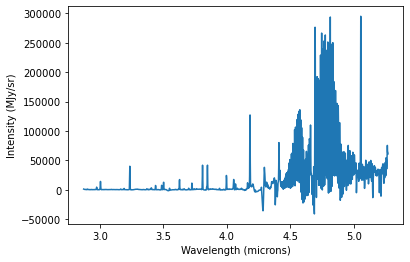

In [22]:
# Read in a 3-D IFU datacube of interest, and header
#first, note the path
protostar_folders = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
protostar_ind = 4
cube_file_list = [glob('Baseline_Subtracted/' + i + '*.fits')[0].replace('\\', '/') for i in protostar_folders] #change the wildcard '*' here!

# Read in a 3-D IFU datacube of interest, and header
#first, note the path
cube_file = cube_file_list[protostar_ind]
hdul = fits.open(cube_file)
cube = fits.getdata(cube_file)
nirspec_cube = SpectralCube.read(hdul[0]) #accessing the cube for data  
header_cube = hdul[0].header

# define the wavelength grid (microns) from the header
# offset_list = [1.95e-3, 2e-3, 9.75e-4, 1.05e-3, 1.825e-3] #done by hand
offset_list = [1.85e-3, 2e-3, 1.1e-3, 1.1e-3, 2.25e-3] #experimental round 2 with initial changes to baselines
wave_offset = offset_list[protostar_ind] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
wave_factor = 1 #/1.001 #for wavelength calibrating
wave_units = 1e6 #to convert from meters to microns
wave = wave_factor * wave_units * nirspec_cube.spectral_axis.value + wave_offset

# make a simple 1d spectrum of the central region, taking sum or median to attempt to account for cosmic rays
# central_sources = [(48,45), (44,43), (47, 52), (41, 45), (46, 48)]
# central_sources = [(48,46), (44,44), (44, 41), (41, 45), (38, 42)] #this one has fewer artifacts
central_sources = [(int(46.57459417809592), int(45.12978229)),  (int(46.73250708463416), int(43.13112798)), (int(46.47088442936513), int(46.6279981)), \
                        (int(41.71119797770727), int(43.61467905)), (int(43.38667807448542), int(43.15705917))]

arc_to_pix = 1 * 2.7777778191699e-05 * 3600.0
center_widths = [int(1 / arc_to_pix)] * 5
flux1 = np.sum(cube[:, central_sources[protostar_ind][0]-center_widths[protostar_ind]:central_sources[protostar_ind][1]+center_widths[protostar_ind],\
                       central_sources[protostar_ind][0]-center_widths[protostar_ind]:central_sources[protostar_ind][1]+center_widths[protostar_ind]], \
                        axis=(1,2)) #for an example of a single pixel
# flux1 = cube[:, int(central_sources[protostar_ind][0]), int(central_sources[protostar_ind][1]) ].astype(np.float32) #for an example of a single pixel
flux1 = np.nan_to_num(flux1)

#plot sample spectrum
plt.plot(wave, flux1)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Intensity (MJy/sr)')

#store spectra into dataframe and save it
df_spectrum = pd.DataFrame({'Wavelength(mic)':wave, 'Flux(MJy/sr)':flux1})
savepath = 'Spectra1D_tests/' + protostar_folders[protostar_ind] + '_baseFit_1dSpectrum.txt'
df_spectrum.to_csv(savepath)

''' after creating file, add to the header

file: 1D spectrum by Adam Rubinstein
protostar: IRAS 16253
stat method: sum
aperture shape: square
aperture side length or diameter: 1 arcsec
additional notes: baseline fitted and subtracted using pybaselines tophat, then jbcd methods. 
additional notes: centered using alma coordinates

'''